# ToDo: 
+ ~~期待値がほぼ 0 になっている理由を探す。回避できるようなら回避~~
+ ~~C = 3 * n_qubits の理由~~ (特に理由はない？)
+ ~~QPU のばらつき改善~~
+ 2 次のトロッターにしてみる

## わかったこと
+ ハミルトニアンをシフトさせなければ成功
+ times = [2 * np.pi * k / C for k in range(n_features)] は失敗
+ times = [np.pi * k / C for k in range(n_features)] は成功

In [1]:
%matplotlib inline
%pip freeze > requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Add the fourier_learning_ibm package to the path
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']


In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import os
from heisenberg_graph import (
    HeisenbergModel,
    get_n_steps,
    get_graph,
    get_positions,
    get_initial_layout,
    get_prob0,
    extract_probs,
)
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Batch
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
import mthree
import pickle
import networkx as nx
from datetime import datetime, timezone
import json
import math

In [ ]:
# Option1: Use IBM Quantum backend.
# If you did not previously save your credentials, use the following line instead:

# !!!!!!!!!
# DANGER: Do not hardcode your token in your code. Use environment variables instead.
service = QiskitRuntimeService(
    channel="ibm_quantum",
    token="YOUR_IBM_QUANTUM_TOKEN",
)
# !!!!!!!!!

# service = QiskitRuntimeService()
# backend_qpu = service.least_busy(simulator=False, interactional=True)
backend_qpu = service.backend("ibm_marrakesh")

# Option2: Use local AerSimulator as the backend.
backend_sim = AerSimulator()

noise_model = NoiseModel.from_backend(backend_qpu)
backend_sim_noisy = AerSimulator(noise_model=noise_model)

print(f"Using backend QPU: {backend_qpu}")
print(f"Using backend simulator: {backend_sim}")
print(f"Using backend noisy simulator: {backend_sim_noisy}")

Using backend QPU: <IBMBackend('ibm_marrakesh')>
Using backend simulator: AerSimulator('aer_simulator')
Using backend noisy simulator: AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'x', 'id', 'cz', 'sx', 'measure']>)


# データセット作成 $\exp(-\beta H)$

In [5]:
n_samples = 120
n_qubits = 10
beta = 1

graph_type = "line"
# ghz_qubits = list(range(n_qubits // 2))
# ghz_qubits = list(range(0, n_qubits, 2))
# print(f"GHZ qubits: {ghz_qubits}")

## Create graph (Demo)

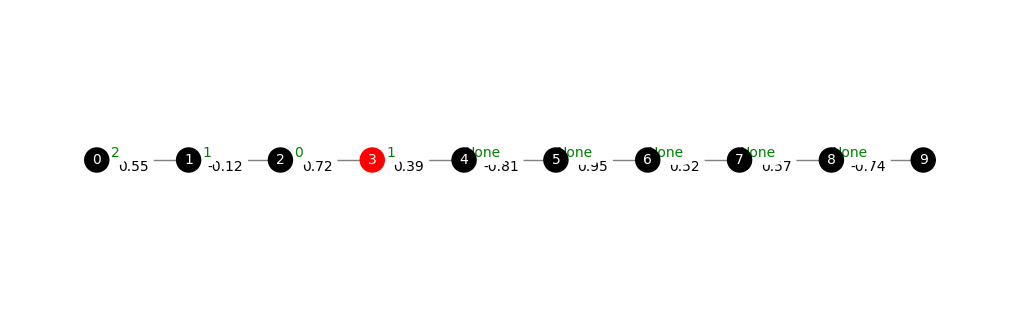

In [6]:
rng = np.random.default_rng(42)
G = get_graph(n_qubits, rng, graph_type)

positions = get_positions(n_qubits, graph_type)

# エッジラベルを作成
edge_J_labels = {edge: f"{G.edges[edge]['J']:.2g}" for edge in G.edges}
# edge_interaction_order_labels = {
#     edge: f"{G.edges[edge]['interaction_order']}" for edge in G.edges
# }
edge_cnot_order_labels = {edge: f"{G.edges[edge]['cnot']['order']}" for edge in G.edges}

# グラフを描画
plt.figure(figsize=(10, 3))
nx.draw(
    G,
    pos=positions,
    with_labels=True,
    node_color=["red" if G.nodes[node]["hadamard"] else "black" for node in G.nodes],
    node_size=300,
    edge_color="gray",
    font_color="white",
    font_size=10,
)

# エッジの重みを描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_J_labels,
    font_size=10,
    font_color="black",
    label_pos=0.6,
    verticalalignment="top",
)

# エッジの 'interaction_order' 属性を描画
# nx.draw_networkx_edge_labels(
#     G,
#     pos=positions,
#     edge_labels=edge_interaction_order_labels,
#     font_size=10,
#     font_color="blue",
#     label_pos=0.4,
#     verticalalignment="bottom",
# )

# エッジの 'cnot' 'order' 属性を描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_cnot_order_labels,
    font_size=10,
    font_color="green",
    label_pos=0.8,
    verticalalignment="bottom",
)

plt.show()

In [7]:
# State |111000> (half 1 and half 0 state) (can be adjusted for other sizes)
state = np.zeros(2**n_qubits, dtype=complex)
index = int("1" * (n_qubits // 2) + "0" * (n_qubits // 2), 2)
state[index] = 1
print("1" * (n_qubits // 2) + "0" * (n_qubits // 2))
print(f"index: {index}")

1111100000
index: 992


## Non Trotter simulation (directly compute the expectation value)

In [8]:
heisenberg = HeisenbergModel(n_qubits, G)

In [9]:
%%timeit
sparse_H = heisenberg.get_sparse_hamiltonian()
sparse_fH = scipy.sparse.linalg.expm(-beta * sparse_H)
sparse_y = np.vdot(state, sparse_fH @ state).real
print(f"sparse_y: {sparse_y}")

/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


sparse_y: 0.43421136110369707
sparse_y: 0.43421136110369707
sparse_y: 0.43421136110369707
sparse_y: 0.43421136110369707
sparse_y: 0.43421136110369707
sparse_y: 0.43421136110369707
sparse_y: 0.43421136110369707
sparse_y: 0.43421136110369707
1.32 s ± 39.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit
H = heisenberg.get_hamiltonian()
fH = scipy.linalg.expm(-beta * H)
y = np.vdot(state, fH @ state).real
print(f"y: {y}")

y: 0.4342113611036969
y: 0.4342113611036969
y: 0.4342113611036969
y: 0.4342113611036973
y: 0.4342113611036969
y: 0.4342113611036973
y: 0.4342113611036973
y: 0.4342113611036969
10.7 s ± 300 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
data = []
# eigvals_list = []
graphs = []
# matrix_norms = []  # For debugging
rng = np.random.default_rng(42)

for i in range(n_samples):
    print(f"Sample {i}/{n_samples}")
    G = get_graph(n_qubits, rng, graph_type)
    Js = [G.edges[edge]["J"] for edge in G.edges]
    heisenberg = HeisenbergModel(n_qubits, G)

    # eigvals = np.linalg.eigvalsh(H)
    # eigvals_list.append(eigvals)
    # matrix_norms.append(np.linalg.norm(H, ord=2))

    # H = heisenberg.get_hamiltonian()
    # fH = scipy.linalg.expm(-beta * H)
    # Compute the expectation value <111000|exp(-beta*H)|111000>
    # y = np.vdot(state, fH @ state).real

    # sparse matrix
    H = heisenberg.H
    fH = scipy.sparse.linalg.expm(-beta * H)
    # Compute the expectation value <111000|exp(-beta*H)|111000>
    y = np.vdot(state, fH @ state).real

    data.append({"Js": Js, "expected_value": y})
    graphs.append(G)

df = pd.DataFrame(data)
df

Sample 0/120
Sample 1/120
Sample 2/120
Sample 3/120
Sample 4/120
Sample 5/120
Sample 6/120
Sample 7/120
Sample 8/120
Sample 9/120
Sample 10/120
Sample 11/120
Sample 12/120
Sample 13/120
Sample 14/120
Sample 15/120
Sample 16/120
Sample 17/120
Sample 18/120
Sample 19/120
Sample 20/120
Sample 21/120
Sample 22/120
Sample 23/120
Sample 24/120
Sample 25/120
Sample 26/120
Sample 27/120
Sample 28/120
Sample 29/120
Sample 30/120
Sample 31/120
Sample 32/120
Sample 33/120
Sample 34/120
Sample 35/120
Sample 36/120
Sample 37/120
Sample 38/120
Sample 39/120
Sample 40/120
Sample 41/120
Sample 42/120
Sample 43/120
Sample 44/120
Sample 45/120
Sample 46/120
Sample 47/120
Sample 48/120
Sample 49/120
Sample 50/120
Sample 51/120
Sample 52/120
Sample 53/120
Sample 54/120
Sample 55/120
Sample 56/120
Sample 57/120
Sample 58/120
Sample 59/120
Sample 60/120
Sample 61/120
Sample 62/120
Sample 63/120
Sample 64/120
Sample 65/120
Sample 66/120
Sample 67/120
Sample 68/120
Sample 69/120
Sample 70/120
Sample 71/120
Sa

,Js,expected_value
0,"[0.5479120971119267, -0.12224312049589536, 0.7...",0.434211
1,"[-0.09922812420886573, -0.25840395153483753, 0...",7.663109
2,"[0.6552623439851641, 0.2633287982441297, 0.516...",2.279938
3,"[-0.9123924684255424, -0.6914210158649043, 0.3...",74.873516
4,"[-0.7401569893290567, -0.04859014754813251, -0...",0.677188
...,...,...
115,"[0.2941435962866503, -0.31527513339989177, -0....",1.090458
116,"[-0.9604671093146167, -0.3469063146564402, -0....",77.342897
117,"[-0.722691007533161, -0.4329584668015416, 0.34...",0.395207
118,"[-0.4897861379452386, 0.25095631382787253, -0....",0.847017


## Pre-process data

In [12]:
df["expected_value"].describe()

count    120.000000
mean       9.250089
std       21.080574
min        0.069583
25%        0.463081
50%        1.735634
75%        7.882326
max      123.393602
Name: expected_value, dtype: float64

In [13]:
# Query the 95% quantile
q = df["expected_value"].quantile(0.95)
filtered_index = df.query(f"expected_value < @q").index
diffrence = df.index.difference(filtered_index)
print(f"Outliers: {diffrence}")

# Remove outliers
df = df.drop(diffrence).reset_index(drop=True)
graphs = [graph for i, graph in enumerate(graphs) if i not in diffrence]

Outliers: Index([3, 28, 61, 82, 100, 116], dtype='int64')


In [14]:
display(df)

n_samples = len(df)

,Js,expected_value
0,"[0.5479120971119267, -0.12224312049589536, 0.7...",0.434211
1,"[-0.09922812420886573, -0.25840395153483753, 0...",7.663109
2,"[0.6552623439851641, 0.2633287982441297, 0.516...",2.279938
3,"[-0.7401569893290567, -0.04859014754813251, -0...",0.677188
4,"[0.6095287149936037, -0.22504324193965108, -0....",1.549202
...,...,...
109,"[0.8950711993319846, -0.2673290228869274, 0.47...",0.155896
110,"[0.2941435962866503, -0.31527513339989177, -0....",1.090458
111,"[-0.722691007533161, -0.4329584668015416, 0.34...",0.395207
112,"[-0.4897861379452386, 0.25095631382787253, -0....",0.847017


## Check eigvals and Configure params

In [15]:
# Plot histogram of eigenvalues
# print(f"Number of samples: {n_samples}")
# eigvals_array = np.array(eigvals_list).flatten()
# plt.hist(eigvals_array, bins=50)
# plt.xlabel("Eigenvalues")
# plt.ylabel("Frequency")
# plt.title("Eigenvalues of Hamiltonian")
# plt.show()

In [16]:
n_features = 5  # Number of Fourier features

# Parameters for the Fourier feature generation
# For shifted Hamiltonian
# C = 20 * n_qubits  # upper bound for eigenvalues (WHY?)
# times = [2 * np.pi * k / C for k in range(n_features)]

# For unshifted Hamiltonian
C = 10 * n_qubits  # upper bound for eigenvalues
times = [np.pi * k / C for k in range(n_features)]

# C = max(matrix_norms)  # upper bound for eigenvalues
print(f"C: {C}")
# print(f"max matrix norm: {max(matrix_norms)}")  # For debugging
print(f"times: {times}")

C: 100
times: [0.0, 0.031415926535897934, 0.06283185307179587, 0.09424777960769379, 0.12566370614359174]


In [17]:
# Only for CP1
%cd fourier_learning_ibm/

/home/jovyan/fourier_learning_ibm


In [18]:
current_time = (
    datetime.now(timezone.utc).isoformat(timespec="minutes").replace("+00:00", "Z")
)

path = f"./data/{current_time}_{n_qubits}_{backend_qpu.name}_{graph_type}"
os.makedirs(path, exist_ok=True)
print(f"current_time: {current_time}")
print(f"Saving data to {path}")

current_time: 2024-11-27T10:30Z
Saving data to ./data/2024-11-27T10:30Z_10_ibm_marrakesh_line


In [19]:
# Save parameters
with open(
    f"./data/{current_time}_{n_qubits}_{backend_qpu.name}_{graph_type}/params.pkl", "wb"
) as f:
    pickle.dump(
        {
            "n_samples": n_samples,
            "n_qubits": n_qubits,
            "backend_qpu_name": backend_qpu.name,
            "beta": beta,
            "C": C,
            "n_features": n_features,
            "times": times,
            "Js": df["Js"].values,
            "graphs": graphs,
            "expected_values": df["expected_value"].values,
        },
        f,
    )

In [20]:
# Load parameters
with open(f"{path}/params.pkl", "rb") as f:
    params = pickle.load(f)

n_samples = params["n_samples"]
n_qubits = params["n_qubits"]
backend_qpu_name = params["backend_qpu_name"]
beta = params["beta"]
C = params["C"]
n_features = params["n_features"]
times = params["times"]
all_Js = params["Js"]
graphs = params["graphs"]
all_expected_values = params["expected_values"]

# Create Fourier feature

## Trotter simulation (Exact)

In [21]:
# Exact simulation
data = []
probs_phase0_exact = {}
probs_phase1_exact = {}
probs_phase2_exact = {}
probs_phase3_exact = {}

# Generate the dataset with Fourier features
for i in range(n_samples):
    print(f"Calculating features for sample {i}/{n_samples}")
    Js = all_Js[i]
    lambda_ref = np.sum(Js)  # Reference eigenvalue.
    heisenberg_exact = HeisenbergModel(n_qubits, graphs[i])
    features_exact = []

    probs_phase0_exact[f"sample{i}"] = {}
    probs_phase1_exact[f"sample{i}"] = {}
    probs_phase2_exact[f"sample{i}"] = {}
    probs_phase3_exact[f"sample{i}"] = {}

    # Compute the Fourier features for different times
    for k in range(n_features):
        prob_phase0 = heisenberg_exact.exact_simulation(times[k], phase=0)
        prob_phase1 = heisenberg_exact.exact_simulation(times[k], phase=1)
        prob_phase2 = heisenberg_exact.exact_simulation(times[k], phase=2)
        prob_phase3 = heisenberg_exact.exact_simulation(times[k], phase=3)

        probs_phase0_exact[f"sample{i}"][f"f_{k}"] = prob_phase0
        probs_phase1_exact[f"sample{i}"][f"f_{k}"] = prob_phase1
        probs_phase2_exact[f"sample{i}"][f"f_{k}"] = prob_phase2
        probs_phase3_exact[f"sample{i}"][f"f_{k}"] = prob_phase3

        inner_product = np.exp(-1j * lambda_ref * times[k]) * (
            (prob_phase0 - prob_phase1) + 1j * (prob_phase2 - prob_phase3)
        )

        # For shifted Hamiltonian
        # inner_product = (
        #     np.exp(-1j * heisenberg_exact.min_eigval_before * times[k]) * inner_product
        # )

        features_exact.append(inner_product.real)
        if k != 0:
            features_exact.append(inner_product.imag)
    data.append([i, *features_exact, all_expected_values[i]])

# Create column names for the DataFrame
columns = []
columns.append("sample_id")
for k in range(n_features):
    columns.append(f"f_{k} Re")
    if k != 0:
        columns.append(f"f_{k} Im")
columns.append("expected_value")

# Convert to a DataFrame
data_exact_df = pd.DataFrame(data, columns=columns)
display(data_exact_df)

# Save the exact data
data_exact_df.to_json(f"{path}/data_exact_df.json")

Calculating features for sample 0/114


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Calculating features for sample 1/114
Calculating features for sample 2/114
Calculating features for sample 3/114
Calculating features for sample 4/114
Calculating features for sample 5/114
Calculating features for sample 6/114
Calculating features for sample 7/114
Calculating features for sample 8/114
Calculating features for sample 9/114
Calculating features for sample 10/114
Calculating features for sample 11/114
Calculating features for sample 12/114
Calculating features for sample 13/114
Calculating features for sample 14/114
Calculating features for sample 15/114
Calculating features for sample 16/114
Calculating features for sample 17/114
Calculating features for sample 18/114
Calculating features for sample 19/114
Calculating features for sample 20/114
Calculating features for sample 21/114
Calculating features for sample 22/114
Calculating features for sample 23/114
Calculating features for sample 24/114
Calculating features for sample 25/114
Calculating features for sample 26

,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,1.0,0.992134,-0.114340,0.968693,-0.226507,0.930143,-0.334372,0.877249,-0.435894,0.434211
1,1,1.0,0.998365,0.040284,0.993473,0.080286,0.985362,0.119726,0.974093,0.158329,7.663109
2,2,1.0,0.997880,-0.027241,0.991535,-0.054284,0.981008,-0.080935,0.966374,-0.107002,2.279938
3,3,1.0,0.999852,-0.015253,0.999410,-0.030504,0.998673,-0.045749,0.997643,-0.060988,0.677188
4,4,1.0,0.998910,-0.011441,0.995646,-0.022780,0.990226,-0.033916,0.982678,-0.044749,1.549202
...,...,...,...,...,...,...,...,...,...,...,...
109,109,1.0,0.998193,-0.059578,0.992781,-0.118935,0.983782,-0.177850,0.971232,-0.236103,0.155896
110,110,1.0,0.998730,-0.018145,0.994938,-0.036035,0.988670,-0.053417,0.980008,-0.070047,1.090458
111,111,1.0,0.996866,-0.069725,0.987491,-0.138897,0.971954,-0.206969,0.950385,-0.273403,0.395207
112,112,1.0,0.999786,-0.016421,0.999144,-0.032844,0.998075,-0.049268,0.996584,-0.065694,0.847017


## Trotter simulation (Simulator, Noise free)

In [22]:
# Create circuits
# 1 jobs - 1 sample
circuits_phase0 = {}
circuits_phase1 = {}
circuits_phase2 = {}
circuits_phase3 = {}
exec_circuits_phase0 = {}
exec_circuits_phase1 = {}
exec_circuits_phase2 = {}
exec_circuits_phase3 = {}
lambda_refs = {}

for i in range(n_samples):
    print(f"Creating circuits for sample {i}/{n_samples}")
    Js = all_Js[i]
    # lambda_refs.append(np.sum(Js))  # Reference eigenvalue.
    lambda_refs[f"sample{i}"] = np.sum(Js)  # Reference eigenvalue.
    heisenberg_sim = HeisenbergModel(n_qubits, graphs[i], backend=backend_sim)

    circuits_phase0[f"sample{i}"] = {}
    circuits_phase1[f"sample{i}"] = {}
    circuits_phase2[f"sample{i}"] = {}
    circuits_phase3[f"sample{i}"] = {}
    exec_circuits_phase0[f"sample{i}"] = {}
    exec_circuits_phase1[f"sample{i}"] = {}
    exec_circuits_phase2[f"sample{i}"] = {}
    exec_circuits_phase3[f"sample{i}"] = {}
    for k in range(n_features):
        n_steps = get_n_steps(times[k])
        circuit_phase0, exec_circuit_phase0 = (
            heisenberg_sim.get_trotter_simulation_circuit(times[k], n_steps, phase=0)
        )
        circuit_phase1, exec_circuit_phase1 = (
            heisenberg_sim.get_trotter_simulation_circuit(times[k], n_steps, phase=1)
        )
        circuit_phase2, exec_circuit_phase2 = (
            heisenberg_sim.get_trotter_simulation_circuit(times[k], n_steps, phase=2)
        )
        circuit_phase3, exec_circuit_phase3 = (
            heisenberg_sim.get_trotter_simulation_circuit(times[k], n_steps, phase=3)
        )

        circuits_phase0[f"sample{i}"][f"f_{k}"] = circuit_phase0
        circuits_phase1[f"sample{i}"][f"f_{k}"] = circuit_phase1
        circuits_phase2[f"sample{i}"][f"f_{k}"] = circuit_phase2
        circuits_phase3[f"sample{i}"][f"f_{k}"] = circuit_phase3
        exec_circuits_phase0[f"sample{i}"][f"f_{k}"] = exec_circuit_phase0
        exec_circuits_phase1[f"sample{i}"][f"f_{k}"] = exec_circuit_phase1
        exec_circuits_phase2[f"sample{i}"][f"f_{k}"] = exec_circuit_phase2
        exec_circuits_phase3[f"sample{i}"][f"f_{k}"] = exec_circuit_phase3

Creating circuits for sample 0/114
Creating circuits for sample 1/114
Creating circuits for sample 2/114
Creating circuits for sample 3/114
Creating circuits for sample 4/114
Creating circuits for sample 5/114
Creating circuits for sample 6/114
Creating circuits for sample 7/114
Creating circuits for sample 8/114
Creating circuits for sample 9/114
Creating circuits for sample 10/114


Creating circuits for sample 11/114
Creating circuits for sample 12/114
Creating circuits for sample 13/114
Creating circuits for sample 14/114
Creating circuits for sample 15/114
Creating circuits for sample 16/114
Creating circuits for sample 17/114
Creating circuits for sample 18/114
Creating circuits for sample 19/114
Creating circuits for sample 20/114
Creating circuits for sample 21/114
Creating circuits for sample 22/114
Creating circuits for sample 23/114
Creating circuits for sample 24/114
Creating circuits for sample 25/114
Creating circuits for sample 26/114
Creating circuits for sample 27/114
Creating circuits for sample 28/114
Creating circuits for sample 29/114
Creating circuits for sample 30/114
Creating circuits for sample 31/114
Creating circuits for sample 32/114
Creating circuits for sample 33/114
Creating circuits for sample 34/114
Creating circuits for sample 35/114
Creating circuits for sample 36/114
Creating circuits for sample 37/114
Creating circuits for sample

In [23]:
# Run jobs in batch
jobs = []  # For AerSimulator, we can't use job ids.
with Batch(backend=backend_sim):
    sampler = Sampler()

    for i in range(n_samples):
        print(f"Running circuits for sample {i}/{n_samples}")
        exec_circuits_per_sample = []
        exec_circuits_per_sample += [
            exec_circuits_phase0[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase1[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase2[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase3[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]

        job = sampler.run(exec_circuits_per_sample)
        jobs.append(job)

Running circuits for sample 0/114
Running circuits for sample 1/114
Running circuits for sample 2/114
Running circuits for sample 3/114
Running circuits for sample 4/114
Running circuits for sample 5/114
Running circuits for sample 6/114
Running circuits for sample 7/114
Running circuits for sample 8/114
Running circuits for sample 9/114
Running circuits for sample 10/114
Running circuits for sample 11/114
Running circuits for sample 12/114
Running circuits for sample 13/114
Running circuits for sample 14/114
Running circuits for sample 15/114
Running circuits for sample 16/114
Running circuits for sample 17/114
Running circuits for sample 18/114
Running circuits for sample 19/114
Running circuits for sample 20/114
Running circuits for sample 21/114
Running circuits for sample 22/114
Running circuits for sample 23/114
Running circuits for sample 24/114
Running circuits for sample 25/114
Running circuits for sample 26/114
Running circuits for sample 27/114
Running circuits for sample 28

Running circuits for sample 63/114
Running circuits for sample 64/114
Running circuits for sample 65/114
Running circuits for sample 66/114
Running circuits for sample 67/114
Running circuits for sample 68/114
Running circuits for sample 69/114
Running circuits for sample 70/114
Running circuits for sample 71/114
Running circuits for sample 72/114
Running circuits for sample 73/114
Running circuits for sample 74/114
Running circuits for sample 75/114
Running circuits for sample 76/114
Running circuits for sample 77/114
Running circuits for sample 78/114
Running circuits for sample 79/114
Running circuits for sample 80/114
Running circuits for sample 81/114
Running circuits for sample 82/114
Running circuits for sample 83/114
Running circuits for sample 84/114
Running circuits for sample 85/114
Running circuits for sample 86/114
Running circuits for sample 87/114
Running circuits for sample 88/114
Running circuits for sample 89/114
Running circuits for sample 90/114
Running circuits for

In [24]:
check_list = []
for i in range(n_samples):
    job_id = jobs[i].job_id()
    check_list.append(
        {
            "Job ID": job_id,
            "sample_id": i,
            "Status": job.status().name,
        }
    )

check_df = pd.DataFrame(check_list)
display(check_df)

,Job ID,sample_id,Status
0,f03b3527-9b14-417d-b910-44455172f172,0,DONE
1,4c4a7417-e395-4d08-b4e6-4660e68bdb76,1,DONE
2,08029361-0f9b-4adb-9964-fd4b76a05d29,2,DONE
3,499718ad-9bff-4c43-a1b5-c0dc1abb97c2,3,DONE
4,e2b77dc7-8fda-4de5-9361-69f6886d3c78,4,DONE
...,...,...,...
109,dac359ae-6ee7-4dbc-a1a9-92de0f741220,109,DONE
110,cd52561d-d6be-4f86-bfa2-367155c9c616,110,DONE
111,9edfab1e-3b99-4cba-947a-ace8de0a762a,111,DONE
112,b5b472cd-f781-46f9-b9b5-ea29a8157f55,112,DONE


In [25]:
# Post-process
data_sim = []
probs_phase0_sim = {}
probs_phase1_sim = {}
probs_phase2_sim = {}
probs_phase3_sim = {}

for i in range(n_samples):
    features = []
    probs_phase0_sim[f"sample{i}"] = {}
    probs_phase1_sim[f"sample{i}"] = {}
    probs_phase2_sim[f"sample{i}"] = {}
    probs_phase3_sim[f"sample{i}"] = {}

    # Compute the Fourier features for different times
    for k in range(n_features):
        # Get results of each phase in a batch
        results_phase0 = jobs[i].result()[:n_features]
        results_phase1 = jobs[i].result()[n_features : 2 * n_features]
        results_phase2 = jobs[i].result()[2 * n_features : 3 * n_features]
        results_phase3 = jobs[i].result()[3 * n_features :]

        prob_phase0 = get_prob0(results_phase0[k], n_qubits)
        prob_phase1 = get_prob0(results_phase1[k], n_qubits)
        prob_phase2 = get_prob0(results_phase2[k], n_qubits)
        prob_phase3 = get_prob0(results_phase3[k], n_qubits)

        probs_phase0_sim[f"sample{i}"][f"f_{k}"] = prob_phase0
        probs_phase1_sim[f"sample{i}"][f"f_{k}"] = prob_phase1
        probs_phase2_sim[f"sample{i}"][f"f_{k}"] = prob_phase2
        probs_phase3_sim[f"sample{i}"][f"f_{k}"] = prob_phase3

        inner_product = np.exp(-1j * lambda_refs[f"sample{i}"] * times[k]) * (
            (prob_phase0 - prob_phase1) + 1j * (prob_phase2 - prob_phase3)
        )

        features.append(inner_product.real)
        if k != 0:
            features.append(inner_product.imag)
    data_sim.append([i, *features, all_expected_values[i]])

# Create column names for the DataFrame
columns = []
columns.append("sample_id")
for k in range(n_features):
    columns.append(f"f_{k} Re")
    if k != 0:
        columns.append(f"f_{k} Im")
columns.append("expected_value")

# Convert to a DataFrame
data_sim_df = pd.DataFrame(data_sim, columns=columns)
display(data_sim_df)

# Save the simulation data
data_sim_df.to_json(f"{path}/data_sim_df.json")

 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No co

,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,1.0,0.990032,-0.126762,0.963714,-0.231758,0.929409,-0.327034,0.874717,-0.434729,0.434211
1,1,1.0,0.997078,0.031999,0.989287,0.064002,0.985441,0.130185,0.971814,0.146574,7.663109
2,2,1.0,0.998400,-0.005142,0.981632,-0.100997,0.983999,-0.064992,0.951564,-0.136156,2.279938
3,3,1.0,0.999765,-0.035675,0.999863,-0.016664,0.999369,-0.039639,0.997643,-0.061603,0.677188
4,4,1.0,1.000386,0.005501,0.999624,-0.018432,0.990937,-0.043433,0.988878,-0.060576,1.549202
...,...,...,...,...,...,...,...,...,...,...,...
109,109,1.0,0.994574,-0.114101,0.990933,-0.134360,0.986303,-0.168250,0.975857,-0.222983,0.155896
110,110,1.0,0.998786,-0.011249,0.997272,-0.025571,0.989379,-0.037711,0.967921,-0.072687,1.090458
111,111,1.0,0.989766,-0.090739,0.988061,-0.125838,0.968285,-0.232866,0.953657,-0.246545,0.395207
112,112,1.0,1.000131,0.032318,0.998890,-0.021292,0.995749,-0.035810,0.996918,-0.081625,0.847017


## Trotter simulation (Simulator, Noisy)

In [26]:
# Create circuits
# 1 jobs - 1 sample
circuits_phase0 = {}
circuits_phase1 = {}
circuits_phase2 = {}
circuits_phase3 = {}
exec_circuits_phase0 = {}
exec_circuits_phase1 = {}
exec_circuits_phase2 = {}
exec_circuits_phase3 = {}

for i in range(n_samples):
    print(f"Creating circuits for sample {i}/{n_samples}")
    Js = all_Js[i]
    heisenberg_sim_noisy = HeisenbergModel(
        n_qubits, graphs[i], backend=backend_sim_noisy
    )

    circuits_phase0[f"sample{i}"] = {}
    circuits_phase1[f"sample{i}"] = {}
    circuits_phase2[f"sample{i}"] = {}
    circuits_phase3[f"sample{i}"] = {}
    exec_circuits_phase0[f"sample{i}"] = {}
    exec_circuits_phase1[f"sample{i}"] = {}
    exec_circuits_phase2[f"sample{i}"] = {}
    exec_circuits_phase3[f"sample{i}"] = {}
    for k in range(n_features):
        n_steps = get_n_steps(times[k])
        circuit_phase0, exec_circuit_phase0 = (
            heisenberg_sim_noisy.get_trotter_simulation_circuit(
                times[k], n_steps, phase=0
            )
        )
        circuit_phase1, exec_circuit_phase1 = (
            heisenberg_sim_noisy.get_trotter_simulation_circuit(
                times[k], n_steps, phase=1
            )
        )
        circuit_phase2, exec_circuit_phase2 = (
            heisenberg_sim_noisy.get_trotter_simulation_circuit(
                times[k], n_steps, phase=2
            )
        )
        circuit_phase3, exec_circuit_phase3 = (
            heisenberg_sim_noisy.get_trotter_simulation_circuit(
                times[k], n_steps, phase=3
            )
        )

        circuits_phase0[f"sample{i}"][f"f_{k}"] = circuit_phase0
        circuits_phase1[f"sample{i}"][f"f_{k}"] = circuit_phase1
        circuits_phase2[f"sample{i}"][f"f_{k}"] = circuit_phase2
        circuits_phase3[f"sample{i}"][f"f_{k}"] = circuit_phase3
        exec_circuits_phase0[f"sample{i}"][f"f_{k}"] = exec_circuit_phase0
        exec_circuits_phase1[f"sample{i}"][f"f_{k}"] = exec_circuit_phase1
        exec_circuits_phase2[f"sample{i}"][f"f_{k}"] = exec_circuit_phase2
        exec_circuits_phase3[f"sample{i}"][f"f_{k}"] = exec_circuit_phase3

Creating circuits for sample 0/114
Creating circuits for sample 1/114
Creating circuits for sample 2/114
Creating circuits for sample 3/114
Creating circuits for sample 4/114
Creating circuits for sample 5/114
Creating circuits for sample 6/114
Creating circuits for sample 7/114
Creating circuits for sample 8/114
Creating circuits for sample 9/114
Creating circuits for sample 10/114
Creating circuits for sample 11/114
Creating circuits for sample 12/114
Creating circuits for sample 13/114
Creating circuits for sample 14/114
Creating circuits for sample 15/114
Creating circuits for sample 16/114
Creating circuits for sample 17/114
Creating circuits for sample 18/114
Creating circuits for sample 19/114


Creating circuits for sample 20/114
Creating circuits for sample 21/114
Creating circuits for sample 22/114
Creating circuits for sample 23/114
Creating circuits for sample 24/114
Creating circuits for sample 25/114
Creating circuits for sample 26/114
Creating circuits for sample 27/114
Creating circuits for sample 28/114
Creating circuits for sample 29/114
Creating circuits for sample 30/114
Creating circuits for sample 31/114
Creating circuits for sample 32/114
Creating circuits for sample 33/114
Creating circuits for sample 34/114
Creating circuits for sample 35/114
Creating circuits for sample 36/114
Creating circuits for sample 37/114
Creating circuits for sample 38/114
Creating circuits for sample 39/114
Creating circuits for sample 40/114
Creating circuits for sample 41/114
Creating circuits for sample 42/114
Creating circuits for sample 43/114
Creating circuits for sample 44/114
Creating circuits for sample 45/114
Creating circuits for sample 46/114
Creating circuits for sample

In [27]:
# Run jobs in batch
jobs = []  # For AerSimulator, we can't use job ids.
with Batch(backend=backend_sim_noisy):
    sampler = Sampler()

    for i in range(n_samples):
        print(f"Running circuits for sample {i}/{n_samples}")
        exec_circuits_per_sample = []
        exec_circuits_per_sample += [
            exec_circuits_phase0[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase1[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase2[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase3[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]

        job = sampler.run(exec_circuits_per_sample)
        jobs.append(job)

Running circuits for sample 0/114
Running circuits for sample 1/114


Running circuits for sample 2/114
Running circuits for sample 3/114
Running circuits for sample 4/114
Running circuits for sample 5/114
Running circuits for sample 6/114
Running circuits for sample 7/114
Running circuits for sample 8/114
Running circuits for sample 9/114
Running circuits for sample 10/114
Running circuits for sample 11/114
Running circuits for sample 12/114
Running circuits for sample 13/114
Running circuits for sample 14/114
Running circuits for sample 15/114
Running circuits for sample 16/114
Running circuits for sample 17/114
Running circuits for sample 18/114
Running circuits for sample 19/114
Running circuits for sample 20/114
Running circuits for sample 21/114
Running circuits for sample 22/114
Running circuits for sample 23/114
Running circuits for sample 24/114
Running circuits for sample 25/114
Running circuits for sample 26/114
Running circuits for sample 27/114
Running circuits for sample 28/114
Running circuits for sample 29/114
Running circuits for sample 

In [28]:
check_list = []
for i in range(n_samples):
    job_id = jobs[i].job_id()
    check_list.append(
        {
            "Job ID": job_id,
            "sample_id": i,
            "Status": job.status().name,
        }
    )

check_df = pd.DataFrame(check_list)
display(check_df)

,Job ID,sample_id,Status
0,53f38292-ca0d-4b2f-9c9b-04c5b779cb36,0,DONE
1,a2109e1a-7624-4826-bb26-4f2c031daaad,1,DONE
2,ce245c30-63c3-43f9-905a-fcbe70b9c2c6,2,DONE
3,798afed5-2445-4efc-ab88-a38096807abd,3,DONE
4,76bbd860-5961-42d2-bf0e-53b7d1c1cfc4,4,DONE
...,...,...,...
109,a7daa771-beca-4368-988d-f6a97a72db72,109,DONE
110,bbf2b513-a2cb-4768-93b7-7767a43bfa0f,110,DONE
111,2033dcca-27ab-4cb9-93ef-9115e9de6d23,111,DONE
112,f4e78019-076f-4d4f-a13c-5c7728253134,112,DONE


In [29]:
# Post-process
data_sim_noisy = []
probs_phase0_sim_noisy = {}
probs_phase1_sim_noisy = {}
probs_phase2_sim_noisy = {}
probs_phase3_sim_noisy = {}

for i in range(n_samples):
    features = []
    probs_phase0_sim_noisy[f"sample{i}"] = {}
    probs_phase1_sim_noisy[f"sample{i}"] = {}
    probs_phase2_sim_noisy[f"sample{i}"] = {}
    probs_phase3_sim_noisy[f"sample{i}"] = {}

    # Compute the Fourier features for different times
    for k in range(n_features):
        # Get results of each phase in a batch
        results_phase0 = jobs[i].result()[:n_features]
        results_phase1 = jobs[i].result()[n_features : 2 * n_features]
        results_phase2 = jobs[i].result()[2 * n_features : 3 * n_features]
        results_phase3 = jobs[i].result()[3 * n_features :]

        prob_phase0 = get_prob0(results_phase0[k], n_qubits)
        prob_phase1 = get_prob0(results_phase1[k], n_qubits)
        prob_phase2 = get_prob0(results_phase2[k], n_qubits)
        prob_phase3 = get_prob0(results_phase3[k], n_qubits)

        probs_phase0_sim_noisy[f"sample{i}"][f"f_{k}"] = prob_phase0
        probs_phase1_sim_noisy[f"sample{i}"][f"f_{k}"] = prob_phase1
        probs_phase2_sim_noisy[f"sample{i}"][f"f_{k}"] = prob_phase2
        probs_phase3_sim_noisy[f"sample{i}"][f"f_{k}"] = prob_phase3

        inner_product = np.exp(-1j * lambda_refs[f"sample{i}"] * times[k]) * (
            (prob_phase0 - prob_phase1) + 1j * (prob_phase2 - prob_phase3)
        )
        features.append(inner_product.real)
        if k != 0:
            features.append(inner_product.imag)
    data_sim_noisy.append([i, *features, all_expected_values[i]])

# Create column names for the DataFrame
columns = []
columns.append("sample_id")
for k in range(n_features):
    columns.append(f"f_{k} Re")
    if k != 0:
        columns.append(f"f_{k} Im")
columns.append("expected_value")

# Convert to a DataFrame
data_sim_noisy_df = pd.DataFrame(data_sim_noisy, columns=columns)
display(data_sim_noisy_df)

# Save the simulation data
data_sim_noisy_df.to_json(f"{path}/data_sim_noisy_df.json")

 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,0.853516,0.602416,-0.036473,0.609162,-0.155817,0.602800,-0.195209,0.577858,-0.249422,0.434211
1,1,0.836914,0.615245,0.048688,0.672880,0.061216,0.613356,0.108955,0.614364,0.116627,7.663109
2,2,0.834961,0.651918,0.012134,0.641798,-0.031753,0.606416,-0.048699,0.630505,0.001273,2.279938
3,3,0.848633,0.643372,-0.027194,0.648267,-0.016374,0.634137,-0.035486,0.645113,-0.056112,0.677188
4,4,0.869141,0.625784,0.016281,0.624922,-0.006616,0.637011,-0.028414,0.612718,0.009461,1.549202
...,...,...,...,...,...,...,...,...,...,...,...
109,109,0.860352,0.620186,-0.063387,0.623236,-0.069722,0.634740,-0.113144,0.642983,-0.155340,0.155896
110,110,0.845703,0.639383,0.018441,0.626269,-0.003950,0.637061,-0.055520,0.602924,-0.061885,1.090458
111,111,0.849609,0.631973,-0.036138,0.625608,-0.101314,0.609689,-0.137028,0.624417,-0.180938,0.395207
112,112,0.858398,0.627925,-0.002395,0.621948,-0.018417,0.628172,-0.067739,0.645768,-0.051850,0.847017


## Trotter simulation (QPU)

In [30]:
# For the case session is expired, you can reinitialize the service with the following line.
backend_qpu = service.backend(backend_qpu.name)

In [31]:
initial_layout = get_initial_layout(n_qubits, graph_type, backend_qpu.name)

In [32]:
# Create circuits
# 1 jobs - 1 sample
circuits_phase0 = {}
circuits_phase1 = {}
circuits_phase2 = {}
circuits_phase3 = {}
exec_circuits_phase0 = {}
exec_circuits_phase1 = {}
exec_circuits_phase2 = {}
exec_circuits_phase3 = {}

for i in range(n_samples):
    print(f"Creating circuits for sample {i}/{n_samples}")
    Js = all_Js[i]
    heisenberg_qpu = HeisenbergModel(n_qubits, graphs[i], backend=backend_qpu)

    circuits_phase0[f"sample{i}"] = {}
    circuits_phase1[f"sample{i}"] = {}
    circuits_phase2[f"sample{i}"] = {}
    circuits_phase3[f"sample{i}"] = {}
    exec_circuits_phase0[f"sample{i}"] = {}
    exec_circuits_phase1[f"sample{i}"] = {}
    exec_circuits_phase2[f"sample{i}"] = {}
    exec_circuits_phase3[f"sample{i}"] = {}
    for k in range(n_features):
        n_steps = get_n_steps(times[k])
        circuit_phase0, exec_circuit_phase0 = (
            heisenberg_qpu.get_trotter_simulation_circuit(
                times[k], n_steps, phase=0, initial_layout=initial_layout
            )
        )
        circuit_phase1, exec_circuit_phase1 = (
            heisenberg_qpu.get_trotter_simulation_circuit(
                times[k], n_steps, phase=1, initial_layout=initial_layout
            )
        )
        circuit_phase2, exec_circuit_phase2 = (
            heisenberg_qpu.get_trotter_simulation_circuit(
                times[k], n_steps, phase=2, initial_layout=initial_layout
            )
        )
        circuit_phase3, exec_circuit_phase3 = (
            heisenberg_qpu.get_trotter_simulation_circuit(
                times[k], n_steps, phase=3, initial_layout=initial_layout
            )
        )

        circuits_phase0[f"sample{i}"][f"f_{k}"] = circuit_phase0
        circuits_phase1[f"sample{i}"][f"f_{k}"] = circuit_phase1
        circuits_phase2[f"sample{i}"][f"f_{k}"] = circuit_phase2
        circuits_phase3[f"sample{i}"][f"f_{k}"] = circuit_phase3
        exec_circuits_phase0[f"sample{i}"][f"f_{k}"] = exec_circuit_phase0
        exec_circuits_phase1[f"sample{i}"][f"f_{k}"] = exec_circuit_phase1
        exec_circuits_phase2[f"sample{i}"][f"f_{k}"] = exec_circuit_phase2
        exec_circuits_phase3[f"sample{i}"][f"f_{k}"] = exec_circuit_phase3

Creating circuits for sample 0/114


Creating circuits for sample 1/114
Creating circuits for sample 2/114
Creating circuits for sample 3/114
Creating circuits for sample 4/114
Creating circuits for sample 5/114
Creating circuits for sample 6/114
Creating circuits for sample 7/114
Creating circuits for sample 8/114
Creating circuits for sample 9/114
Creating circuits for sample 10/114
Creating circuits for sample 11/114
Creating circuits for sample 12/114
Creating circuits for sample 13/114
Creating circuits for sample 14/114
Creating circuits for sample 15/114
Creating circuits for sample 16/114
Creating circuits for sample 17/114
Creating circuits for sample 18/114
Creating circuits for sample 19/114
Creating circuits for sample 20/114
Creating circuits for sample 21/114
Creating circuits for sample 22/114
Creating circuits for sample 23/114
Creating circuits for sample 24/114
Creating circuits for sample 25/114
Creating circuits for sample 26/114
Creating circuits for sample 27/114
Creating circuits for sample 28/114
C

before transpile
circuit depth: 21
count_ops: OrderedDict([('cx', 36), ('rx', 14), ('rz', 14), ('rzx', 14), ('measure', 10), ('h', 2), ('barrier', 1)])


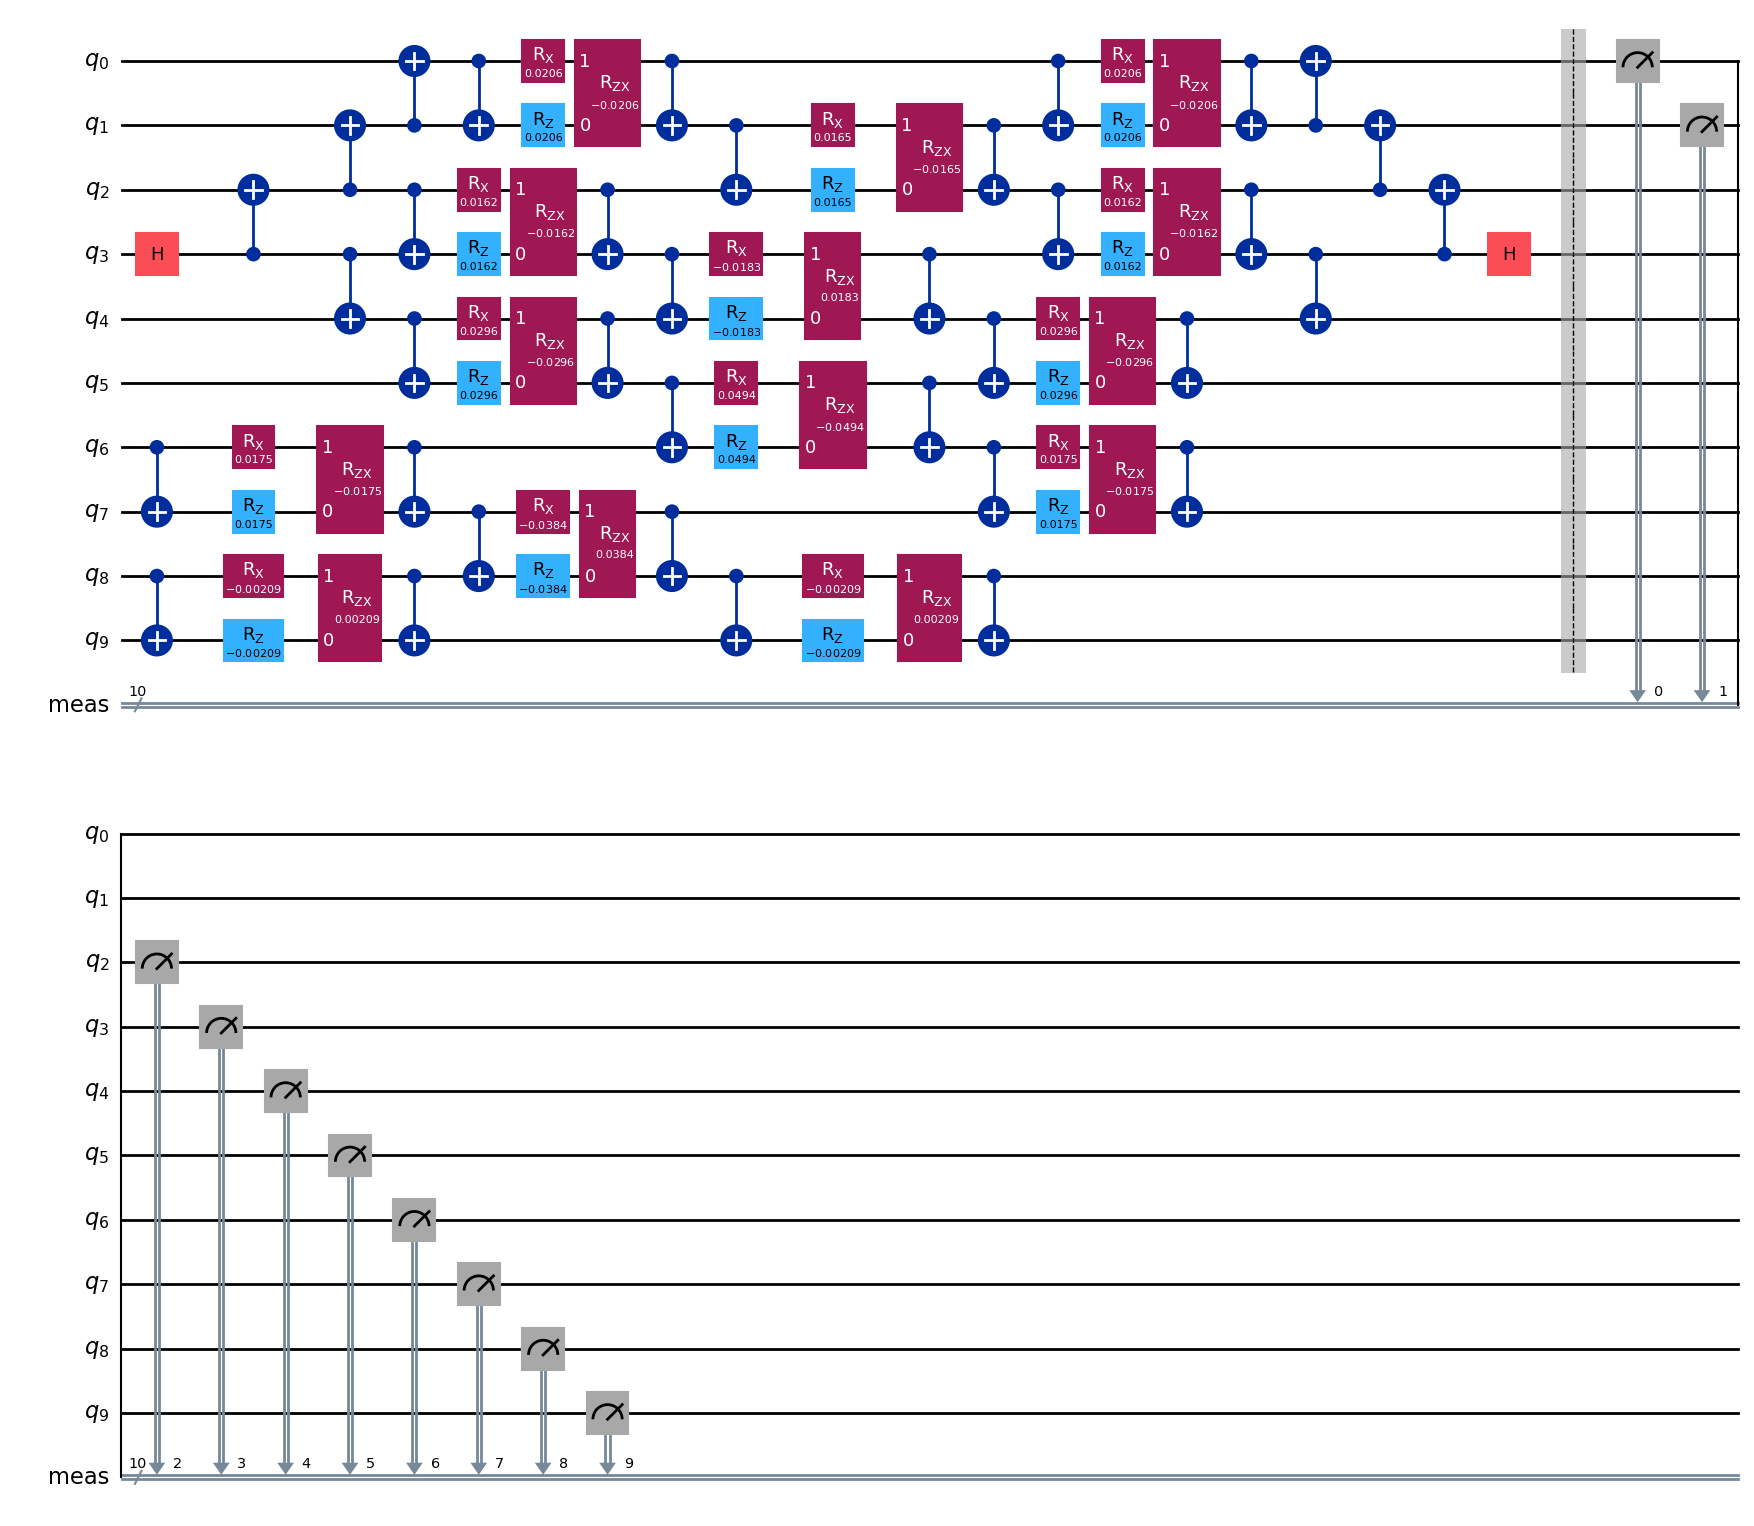

In [33]:
# Check a partial circuit
sample_id = 2
feature_id = 1

print("before transpile")
print(
    f"circuit depth: {circuits_phase0[f'sample{sample_id}'][f'f_{feature_id}'].depth()}"
)
print(
    f"count_ops: {circuits_phase0[f'sample{sample_id}'][f'f_{feature_id}'].count_ops()}"
)
circuits_phase0[f"sample{sample_id}"][f"f_{feature_id}"].draw(
    output="mpl", idle_wires=False
)

after transpile
circuit depth: 51
count_ops: OrderedDict([('sx', 116), ('rz', 106), ('cz', 46), ('measure', 10), ('x', 7), ('barrier', 1)])


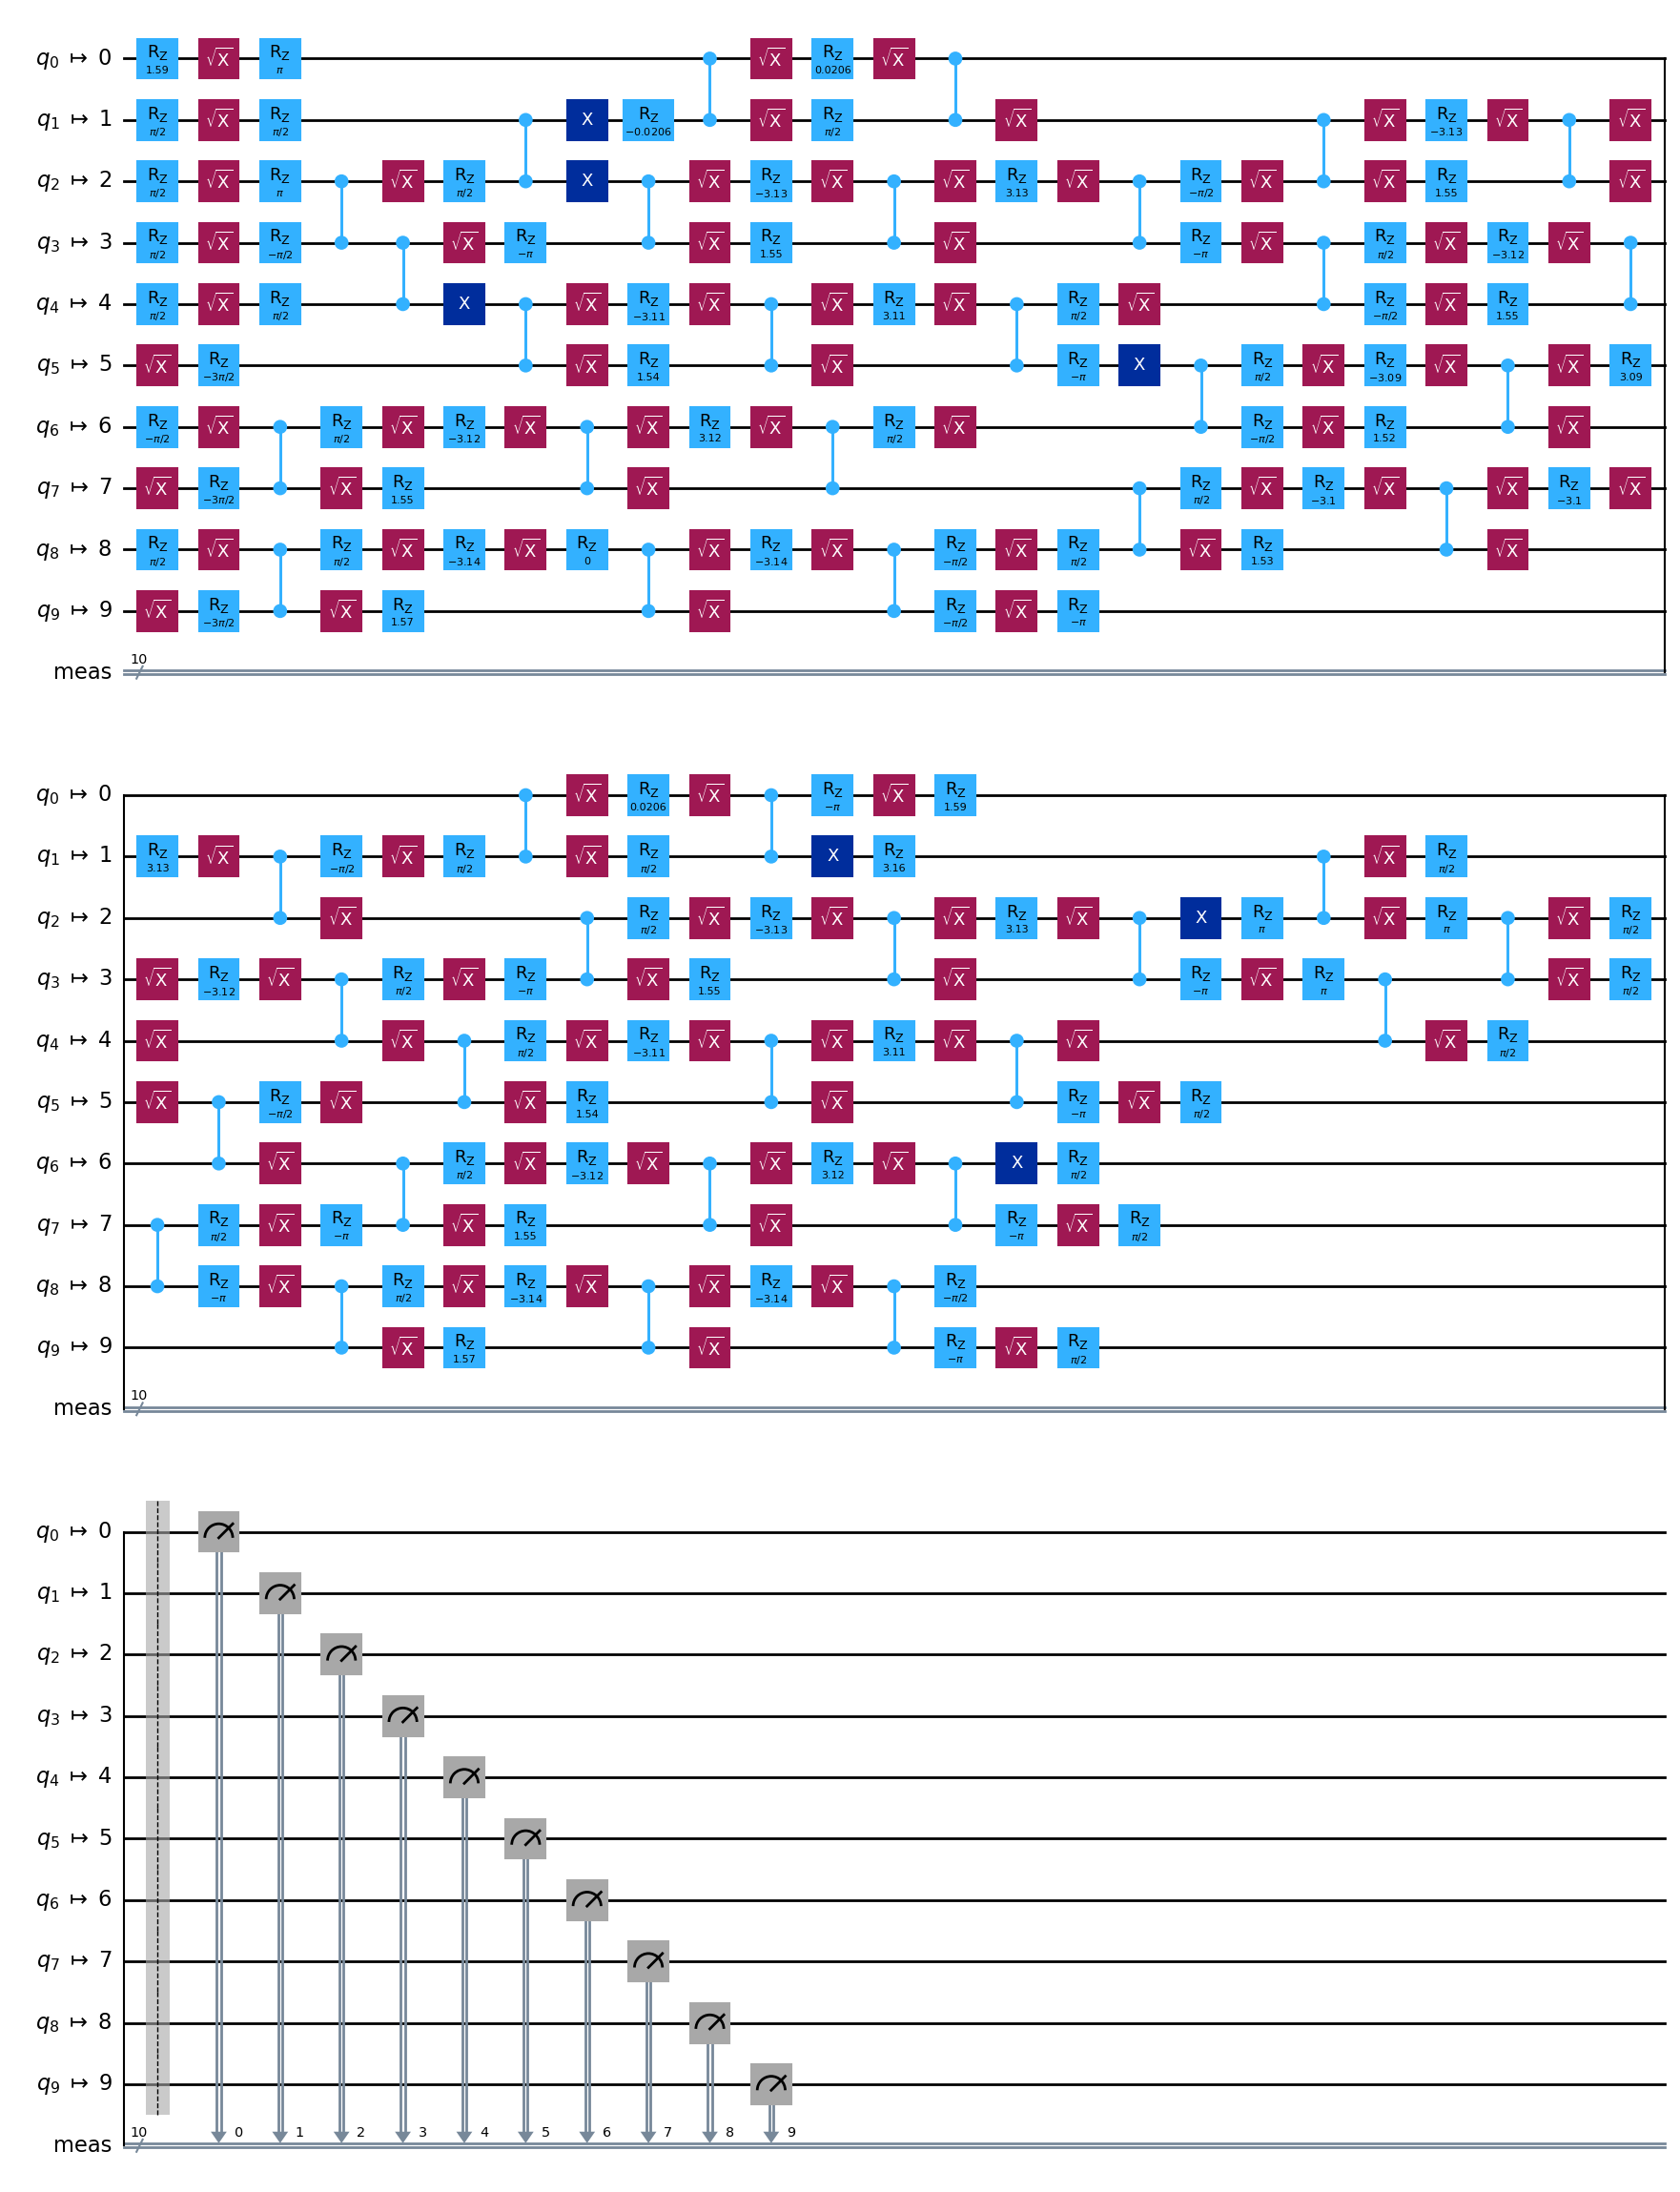

In [34]:
print("after transpile")
print(
    f"circuit depth: {exec_circuits_phase0[f'sample{sample_id}'][f'f_{feature_id}'].depth()}"
)
print(
    f"count_ops: {exec_circuits_phase0[f'sample{sample_id}'][f'f_{feature_id}'].count_ops()}"
)
exec_circuits_phase0[f"sample{sample_id}"][f"f_{feature_id}"].draw(
    output="mpl", idle_wires=False
)

In [35]:
# Run jobs in batch
job_ids = []
mit = mthree.M3Mitigation(backend_qpu)
with Batch(backend=backend_qpu) as batch:
    sampler = Sampler()
    mit.cals_from_system(runtime_mode=batch)
    # Turn on dynamical decoupling.
    sampler.options.dynamical_decoupling.enable = True

    for i in range(n_samples):
        print(f"Submitting circuits for sample {i}/{n_samples}")
        exec_circuits_per_sample = []
        exec_circuits_per_sample += [
            exec_circuits_phase0[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase1[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase2[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase3[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]

        job = sampler.run(exec_circuits_per_sample)
        job_ids.append(job.job_id())

Submitting circuits for sample 0/114
Submitting circuits for sample 1/114
Submitting circuits for sample 2/114
Submitting circuits for sample 3/114
Submitting circuits for sample 4/114
Submitting circuits for sample 5/114
Submitting circuits for sample 6/114
Submitting circuits for sample 7/114


Submitting circuits for sample 8/114
Submitting circuits for sample 9/114
Submitting circuits for sample 10/114
Submitting circuits for sample 11/114
Submitting circuits for sample 12/114
Submitting circuits for sample 13/114
Submitting circuits for sample 14/114
Submitting circuits for sample 15/114
Submitting circuits for sample 16/114
Submitting circuits for sample 17/114


/opt/conda/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:822: UserWarning: The backend ibm_marrakesh currently has a status of internal.
  warnings.warn(


Submitting circuits for sample 18/114
Submitting circuits for sample 19/114
Submitting circuits for sample 20/114
Submitting circuits for sample 21/114
Submitting circuits for sample 22/114
Submitting circuits for sample 23/114
Submitting circuits for sample 24/114
Submitting circuits for sample 25/114
Submitting circuits for sample 26/114
Submitting circuits for sample 27/114
Submitting circuits for sample 28/114
Submitting circuits for sample 29/114
Submitting circuits for sample 30/114
Submitting circuits for sample 31/114
Submitting circuits for sample 32/114
Submitting circuits for sample 33/114
Submitting circuits for sample 34/114
Submitting circuits for sample 35/114
Submitting circuits for sample 36/114
Submitting circuits for sample 37/114
Submitting circuits for sample 38/114
Submitting circuits for sample 39/114
Submitting circuits for sample 40/114
Submitting circuits for sample 41/114
Submitting circuits for sample 42/114
Submitting circuits for sample 43/114
Submitting c

In [39]:
with open(f"{path}/first_try_job_ids.txt", "w") as f:
    for job_id in job_ids:
        f.write(f"{job_id}\n")

first_try_started_at = batch.details()["started_at"]

In [40]:
# Note: This line can be finished only after the calibration job (tagged with "M3 calibration") is finished.
mit.cals_to_file(f"{path}/calibrations_{first_try_started_at}.json")

with open(f"{path}/first_try_started_at.txt", "w") as f:
    f.write(first_try_started_at)

## Post process (QPU)

In [41]:
# Load the params, job IDs and started_at time
# current_time = "2024-11-14T05:27:22.407Z"
with open(f"{path}/params.pkl", "rb") as f:
    params = pickle.load(f)
backend_qpu_name = params["backend_qpu_name"]

In [44]:
with open(f"{path}/first_try_job_ids.txt", "r") as f:
    first_try_job_ids = [job_id.strip() for job_id in f.readlines()]
with open(f"{path}/first_try_started_at.txt", "r") as f:
    first_try_started_at = f.read()

# Load calibration data
cals_file = f"{path}/calibrations_{first_try_started_at}.json"
mit = mthree.M3Mitigation(backend_qpu)
mit.cals_from_file(cals_file)

In [45]:
# Scan the status of the jobs
successful_job_ids_and_samples = {}
failed_job_ids_ids_and_samples = {}
successful_results = {}

for i in range(n_samples):
    print(f"Checking job {i}/{n_samples}")
    job_id = first_try_job_ids[i]
    job = service.job(job_id)

    if job.status() == "DONE":
        successful_job_ids_and_samples[f"sample{i}"] = job_id
        successful_results[f"sample{i}"] = job.result()
    elif job.status() == "ERROR":
        failed_job_ids_ids_and_samples[f"sample{i}"] = job_id

print()
print("successful samples and job ids")
for sample_id, job_id in successful_job_ids_and_samples.items():
    print(f"{sample_id}: {job_id}")
print()
print("failed samples and job ids")
for sample_id, job_id in failed_job_ids_ids_and_samples.items():
    print(f"{sample_id}: {job_id}")
print()
print(f"Success rate: { len(successful_job_ids_and_samples) / n_samples }")

with open(f"{path}/successful_job_ids_and_samples.json", "w") as f:
    json.dump(successful_job_ids_and_samples, f)
with open(f"{path}/failed_job_ids_ids_and_samples.json", "w") as f:
    json.dump(failed_job_ids_ids_and_samples, f)

Checking job 0/114
Checking job 1/114
Checking job 2/114
Checking job 3/114
Checking job 4/114
Checking job 5/114
Checking job 6/114
Checking job 7/114
Checking job 8/114
Checking job 9/114
Checking job 10/114
Checking job 11/114
Checking job 12/114
Checking job 13/114
Checking job 14/114
Checking job 15/114
Checking job 16/114
Checking job 17/114
Checking job 18/114
Checking job 19/114
Checking job 20/114
Checking job 21/114
Checking job 22/114
Checking job 23/114
Checking job 24/114
Checking job 25/114
Checking job 26/114
Checking job 27/114
Checking job 28/114
Checking job 29/114
Checking job 30/114
Checking job 31/114
Checking job 32/114
Checking job 33/114
Checking job 34/114
Checking job 35/114
Checking job 36/114
Checking job 37/114
Checking job 38/114
Checking job 39/114
Checking job 40/114
Checking job 41/114
Checking job 42/114
Checking job 43/114
Checking job 44/114
Checking job 45/114
Checking job 46/114
Checking job 47/114
Checking job 48/114
Checking job 49/114
Checking j

In [46]:
# Load parameters
with open(f"{path}/params.pkl", "rb") as f:
    params = pickle.load(f)

n_samples = params["n_samples"]
n_qubits = params["n_qubits"]
backend_qpu_name = params["backend_qpu_name"]
beta = params["beta"]
C = params["C"]
n_features = params["n_features"]
times = params["times"]
all_Js = params["Js"]
graphs = params["graphs"]
all_expected_values = params["expected_values"]

In [47]:
# Note: this is only for the successful jobs

data_qpu_nmit = []
data_qpu_mit = []
probs_phase0_nmit = {}
probs_phase1_nmit = {}
probs_phase2_nmit = {}
probs_phase3_nmit = {}
probs_phase0_mit = {}
probs_phase1_mit = {}
probs_phase2_mit = {}
probs_phase3_mit = {}

# Note: sample_id is string, not integer
for sample_id, result in successful_results.items():
    print(f"Processing job {sample_id}")
    features_nmit = []
    features_mit = []
    probs_phase0_nmit[sample_id] = {}
    probs_phase1_nmit[sample_id] = {}
    probs_phase2_nmit[sample_id] = {}
    probs_phase3_nmit[sample_id] = {}
    probs_phase0_mit[sample_id] = {}
    probs_phase1_mit[sample_id] = {}
    probs_phase2_mit[sample_id] = {}
    probs_phase3_mit[sample_id] = {}

    for k in range(n_features):
        # Get results of each phase in a batch
        # phase_results = result[4 * k : 4 * k + 4]
        # probs = [
        #     get_prob0(phase_result, n_qubits, mit) for phase_result in phase_results
        # ]

        # Get results of each phase in a batch
        results_phase0 = result[:n_features]
        results_phase1 = result[n_features : 2 * n_features]
        results_phase2 = result[2 * n_features : 3 * n_features]
        results_phase3 = result[3 * n_features :]

        prob_phase0_nmit, prob_phase0_mit = get_prob0(results_phase0[k], n_qubits, mit)
        prob_phase1_nmit, prob_phase1_mit = get_prob0(results_phase1[k], n_qubits, mit)
        prob_phase2_nmit, prob_phase2_mit = get_prob0(results_phase2[k], n_qubits, mit)
        prob_phase3_nmit, prob_phase3_mit = get_prob0(results_phase3[k], n_qubits, mit)

        if prob_phase0_mit > 1:
            prob_phase0_mit = 1
        elif prob_phase0_mit < 0:
            prob_phase0_mit = 0
        if prob_phase1_mit > 1:
            prob_phase1_mit = 1
        elif prob_phase1_mit < 0:
            prob_phase1_mit = 0
        if prob_phase2_mit > 1:
            prob_phase2_mit = 1
        elif prob_phase2_mit < 0:
            prob_phase2_mit = 0
        if prob_phase3_mit > 1:
            prob_phase3_mit = 1
        elif prob_phase3_mit < 0:
            prob_phase3_mit = 0

        probs_phase0_nmit[sample_id][f"f_{k}"] = prob_phase0_nmit
        probs_phase1_nmit[sample_id][f"f_{k}"] = prob_phase1_nmit
        probs_phase2_nmit[sample_id][f"f_{k}"] = prob_phase2_nmit
        probs_phase3_nmit[sample_id][f"f_{k}"] = prob_phase3_nmit
        probs_phase0_mit[sample_id][f"f_{k}"] = prob_phase0_mit
        probs_phase1_mit[sample_id][f"f_{k}"] = prob_phase1_mit
        probs_phase2_mit[sample_id][f"f_{k}"] = prob_phase2_mit
        probs_phase3_mit[sample_id][f"f_{k}"] = prob_phase3_mit

        inner_product_nmit = np.exp(-1j * lambda_refs[sample_id] * times[k]) * (
            (prob_phase0_nmit - prob_phase1_nmit)
            + 1j * (prob_phase2_nmit - prob_phase3_nmit)
        )
        inner_product_mit = np.exp(-1j * lambda_refs[sample_id] * times[k]) * (
            (prob_phase0_mit - prob_phase1_mit)
            + 1j * (prob_phase2_mit - prob_phase3_mit)
        )
        features_nmit.append(inner_product_nmit.real)
        features_mit.append(inner_product_mit.real)
        if k != 0:
            features_nmit.append(inner_product_nmit.imag)
            features_mit.append(inner_product_mit.imag)

    # Because sample_id is string (e.g. "sample0"), convert it to integer.
    sample_id_int = int(sample_id.replace("sample", ""))
    data_qpu_nmit.append(
        [sample_id_int, *features_nmit, all_expected_values[sample_id_int]]
    )
    data_qpu_mit.append(
        [sample_id_int, *features_mit, all_expected_values[sample_id_int]]
    )

# Create column names for the DataFrame
columns = []
columns.append("sample_id")
for k in range(n_features):
    columns.append(f"f_{k} Re")
    if k != 0:
        columns.append(f"f_{k} Im")
columns.append("expected_value")

# Convert to a DataFrame
data_qpu_nmit_df = pd.DataFrame(data_qpu_mit, columns=columns)
data_qpu_mit_df = pd.DataFrame(data_qpu_nmit, columns=columns)
print("QPU no mitigation")
display(data_qpu_nmit_df)
print("QPU with mitigation")
display(data_qpu_mit_df)

# Save the qpu data
data_qpu_nmit_df.to_json(f"{path}/data_qpu_nmit_df.json")
data_qpu_mit_df.to_json(f"{path}/data_qpu_mit_df.json")

Processing job sample0
Processing job sample1
Processing job sample2
Processing job sample3
Processing job sample4
Processing job sample5
Processing job sample6
Processing job sample7
Processing job sample8
Processing job sample9
Processing job sample10
Processing job sample11
Processing job sample12
Processing job sample13
Processing job sample14
Processing job sample15
Processing job sample16
Processing job sample17
Processing job sample18
Processing job sample19
Processing job sample20
Processing job sample21
Processing job sample22
Processing job sample23
Processing job sample24
Processing job sample25
Processing job sample26
Processing job sample27
Processing job sample28
Processing job sample29
Processing job sample30
Processing job sample31
Processing job sample32
Processing job sample33
Processing job sample34
Processing job sample35
Processing job sample36
Processing job sample37
Processing job sample38
Processing job sample39
Processing job sample40
Processing job sample41
Pr

,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,0.991547,0.725689,-0.166538,0.659061,-0.314613,0.610325,-0.398027,0.551755,-0.447488,0.434211
1,1,0.986223,0.729158,-0.075785,0.710250,-0.031053,0.694914,-0.082685,0.714554,-0.045493,7.663109
2,2,0.977645,0.629518,-0.339964,0.583426,-0.388228,0.603088,-0.349185,0.632646,-0.304993,2.279938
3,3,0.993367,0.733067,-0.107472,0.728334,-0.115812,0.700070,-0.203891,0.735103,-0.045299,0.677188
4,4,0.973383,0.725254,-0.135688,0.720682,-0.155427,0.701957,-0.116788,0.706733,-0.139004,1.549202
...,...,...,...,...,...,...,...,...,...,...,...
109,109,0.927811,0.585124,-0.301485,0.556675,-0.325996,0.585447,-0.277012,0.587338,-0.345372,0.155896
110,110,0.913003,0.649186,-0.216388,0.623086,-0.252352,0.631836,-0.233393,0.631503,-0.209495,1.090458
111,111,0.918552,0.623706,-0.216955,0.628941,-0.217876,0.631986,-0.233180,0.564081,-0.339005,0.395207
112,112,0.926494,0.698890,-0.011408,0.679650,-0.105273,0.697897,-0.102691,0.656228,-0.241237,0.847017


QPU with mitigation


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,0.827148,0.604249,-0.138114,0.549272,-0.262105,0.508757,-0.331685,0.459517,-0.372491,0.434211
1,1,0.822998,0.607652,-0.063371,0.591785,-0.025905,0.579054,-0.069488,0.595424,-0.038141,7.663109
2,2,0.815186,0.524594,-0.283644,0.486223,-0.323801,0.502630,-0.291434,0.527000,-0.254416,2.279938
3,3,0.828125,0.611419,-0.089461,0.607291,-0.096347,0.584034,-0.170155,0.612915,-0.038067,0.677188
4,4,0.811279,0.604749,-0.112921,0.600432,-0.129156,0.585389,-0.097473,0.588790,-0.115266,1.549202
...,...,...,...,...,...,...,...,...,...,...,...
109,109,0.778564,0.489479,-0.252525,0.465858,-0.272830,0.490393,-0.231344,0.490728,-0.289312,0.155896
110,110,0.769775,0.543047,-0.181196,0.521532,-0.210281,0.528858,-0.195274,0.528044,-0.175014,1.090458
111,111,0.767822,0.521974,-0.181573,0.525918,-0.182180,0.528273,-0.194576,0.472149,-0.283683,0.395207
112,112,0.778320,0.584439,-0.010042,0.568435,-0.088323,0.583776,-0.085543,0.548263,-0.201259,0.847017


## Plot data

In [48]:
# For debugging
# dummy_successful_results = {}
# for i in range(n_samples):
#     dummy_successful_results[f"sample{i}"] = None

# successful_results = dummy_successful_results

In [49]:
probs_phase0_exact_extracted = extract_probs(
    probs_phase0_exact, successful_results.keys()
)
probs_phase1_exact_extracted = extract_probs(
    probs_phase1_exact, successful_results.keys()
)
probs_phase2_exact_extracted = extract_probs(
    probs_phase2_exact, successful_results.keys()
)
probs_phase3_exact_extracted = extract_probs(
    probs_phase3_exact, successful_results.keys()
)

probs_phase0_sim_extracted = extract_probs(probs_phase0_sim, successful_results.keys())
probs_phase1_sim_extracted = extract_probs(probs_phase1_sim, successful_results.keys())
probs_phase2_sim_extracted = extract_probs(probs_phase2_sim, successful_results.keys())
probs_phase3_sim_extracted = extract_probs(probs_phase3_sim, successful_results.keys())

probs_phase0_sim_noisy_extracted = extract_probs(
    probs_phase0_sim_noisy, successful_results.keys()
)
probs_phase1_sim_noisy_extracted = extract_probs(
    probs_phase1_sim_noisy, successful_results.keys()
)
probs_phase2_sim_noisy_extracted = extract_probs(
    probs_phase2_sim_noisy, successful_results.keys()
)
probs_phase3_sim_noisy_extracted = extract_probs(
    probs_phase3_sim_noisy, successful_results.keys()
)

probs_phase0_nmit_extracted = extract_probs(
    probs_phase0_nmit, successful_results.keys()
)
probs_phase1_nmit_extracted = extract_probs(
    probs_phase1_nmit, successful_results.keys()
)
probs_phase2_nmit_extracted = extract_probs(
    probs_phase2_nmit, successful_results.keys()
)
probs_phase3_nmit_extracted = extract_probs(
    probs_phase3_nmit, successful_results.keys()
)

probs_phase0_mit_extracted = extract_probs(probs_phase0_mit, successful_results.keys())
probs_phase1_mit_extracted = extract_probs(probs_phase1_mit, successful_results.keys())
probs_phase2_mit_extracted = extract_probs(probs_phase2_mit, successful_results.keys())
probs_phase3_mit_extracted = extract_probs(probs_phase3_mit, successful_results.keys())

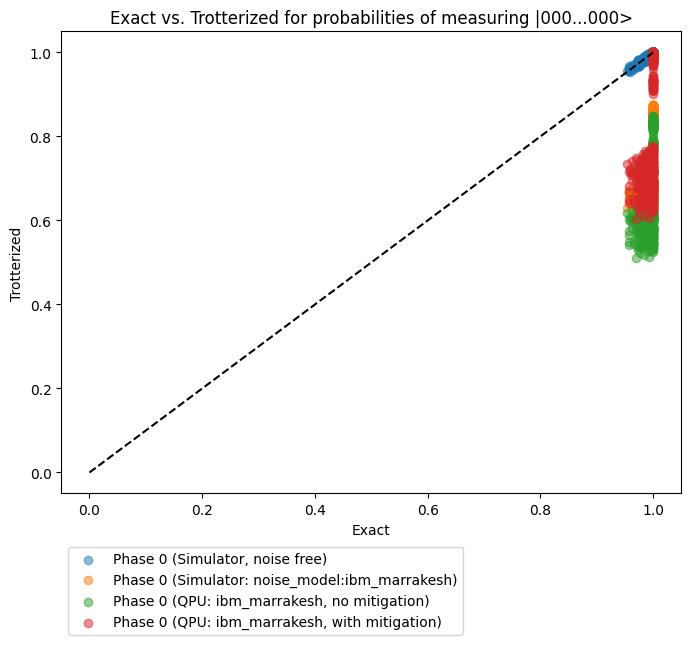

In [50]:
# Plot exact vs. Trotterized results
plt.figure(figsize=(8, 6))
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_sim_extracted,
    label=f"Phase 0 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_sim_noisy_extracted,
    label=f"Phase 0 (Simulator: noise_model:{backend_qpu.name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_nmit_extracted,
    label=f"Phase 0 (QPU: {backend_qpu.name}, no mitigation)",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_mit_extracted,
    label=f"Phase 0 (QPU: {backend_qpu.name}, with mitigation)",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

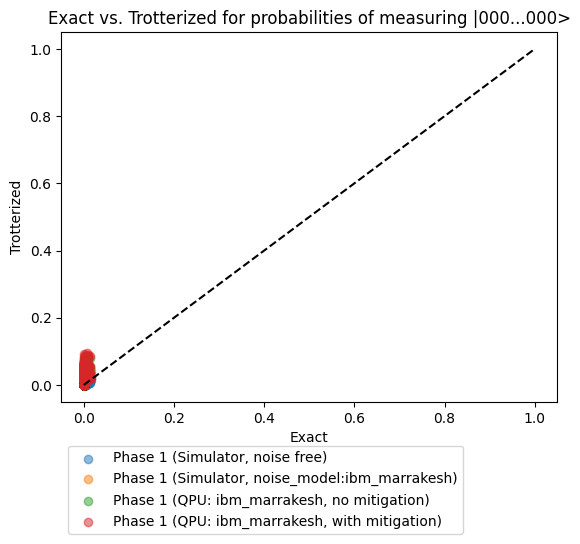

In [51]:
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_sim_extracted,
    label=f"Phase 1 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_sim_noisy_extracted,
    label=f"Phase 1 (Simulator, noise_model:{backend_qpu.name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_nmit_extracted,
    label=f"Phase 1 (QPU: {backend_qpu.name}, no mitigation)",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_mit_extracted,
    label=f"Phase 1 (QPU: {backend_qpu.name}, with mitigation)",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

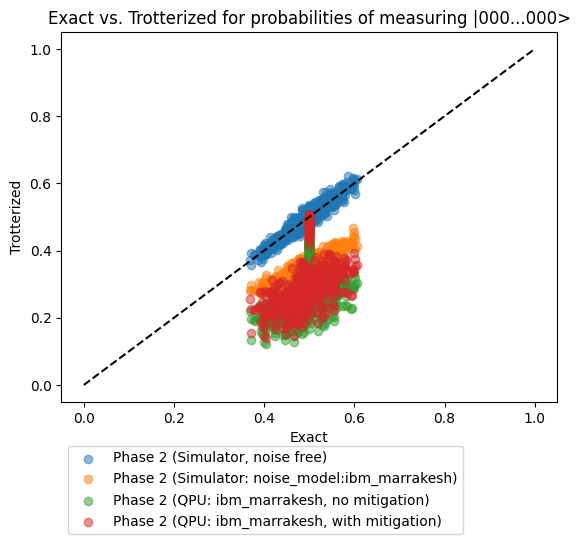

In [52]:
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_sim_extracted,
    label=f"Phase 2 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_sim_noisy_extracted,
    label=f"Phase 2 (Simulator: noise_model:{backend_qpu.name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_nmit_extracted,
    label=f"Phase 2 (QPU: {backend_qpu.name}, no mitigation)",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_mit_extracted,
    label=f"Phase 2 (QPU: {backend_qpu.name}, with mitigation)",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")

plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

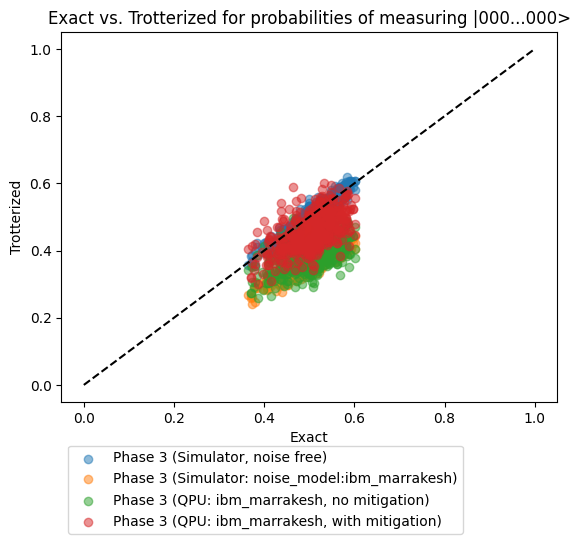

In [53]:
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_sim_extracted,
    label=f"Phase 3 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_sim_noisy_extracted,
    label=f"Phase 3 (Simulator: noise_model:{backend_qpu.name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_nmit_extracted,
    label=f"Phase 3 (QPU: {backend_qpu.name}, no mitigation)",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_mit_extracted,
    label=f"Phase 3 (QPU: {backend_qpu.name}, with mitigation)",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()